In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [3]:
# loading the data
data_dir = '/kaggle/input/lung-cancer-histopathological-after-prerpocessing/data_after_prerocessing'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths               labels
0      /kaggle/input/lung-cancer-histopathological-af...  Lung_adenocarcinoma
1      /kaggle/input/lung-cancer-histopathological-af...  Lung_adenocarcinoma
2      /kaggle/input/lung-cancer-histopathological-af...  Lung_adenocarcinoma
3      /kaggle/input/lung-cancer-histopathological-af...  Lung_adenocarcinoma
4      /kaggle/input/lung-cancer-histopathological-af...  Lung_adenocarcinoma
...                                                  ...                  ...
14995  /kaggle/input/lung-cancer-histopathological-af...   Lung_benign_tissue
14996  /kaggle/input/lung-cancer-histopathological-af...   Lung_benign_tissue
14997  /kaggle/input/lung-cancer-histopathological-af...   Lung_benign_tissue
14998  /kaggle/input/lung-cancer-histopathological-af...   Lung_benign_tissue
14999  /kaggle/input/lung-cancer-histopathological-af...   Lung_benign_tissue

[15000 rows x 2 columns]

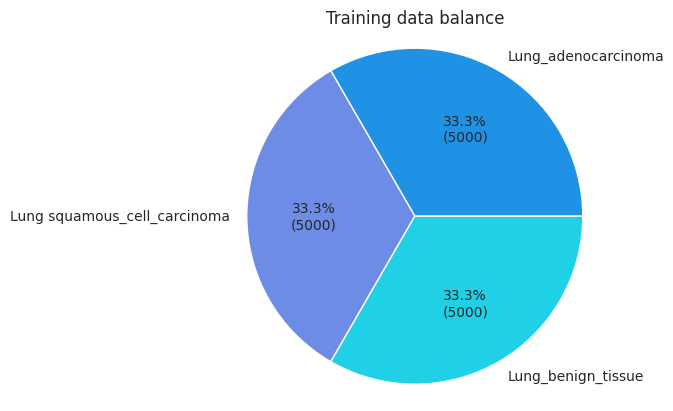

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [5]:
# data --> 70% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.7, shuffle = True, random_state = 42)

# test data --> 20% train data && 10% (test, val)
test_df, valid_df = train_test_split(ts_df, train_size = 2/3, shuffle = True, random_state = 42)

In [6]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 10500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


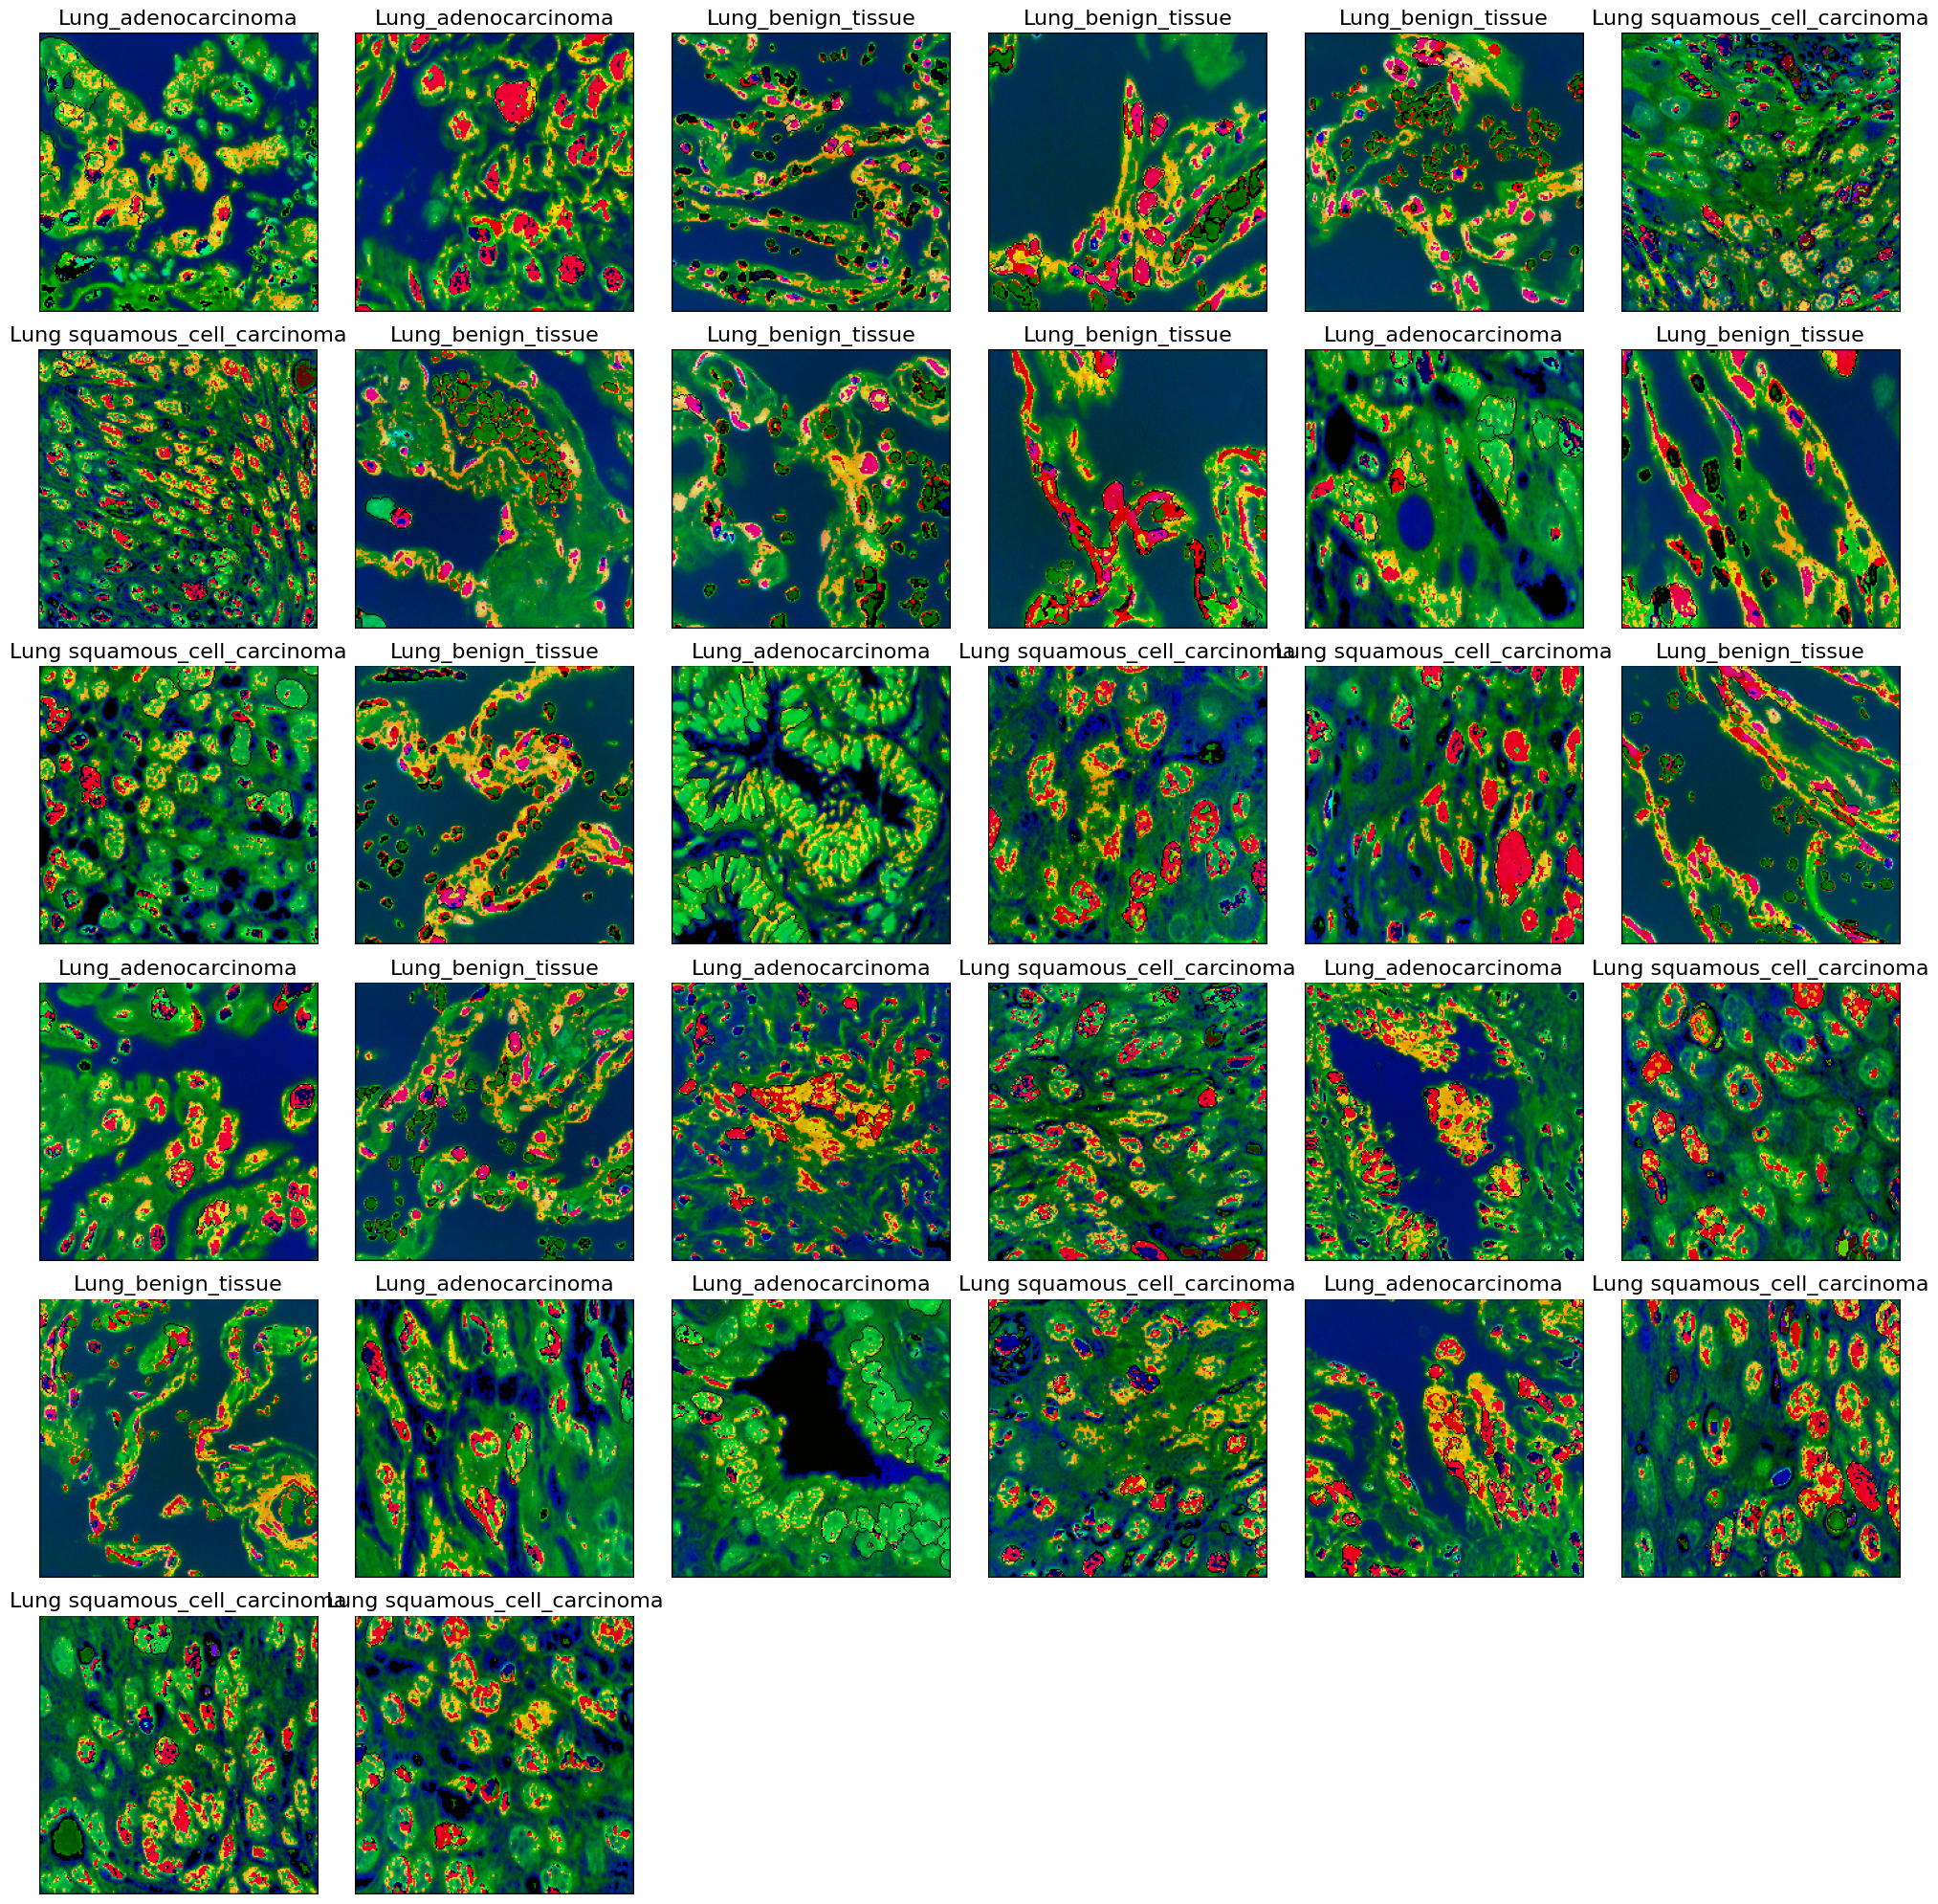

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.layers import Dense, Dropout

# Define a dense block function
def dense_block(units, dropout_rate):
    def block(x):
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        return x
    return block


In [9]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.models import Model

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_counts = len(list(train_gen.class_indices.keys()))  # Define the number of classes

# Load the pre-trained EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=img_shape, pooling=None)

# Add custom layers on top for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation="softmax")(x)

# Create the model
EfficientNetB3_model = Model(inputs=base_model.input, outputs=predictions)

# Display the model summary
EfficientNetB3_model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,990,642 (41.93 MB)

 Trainable params: 10,900,267 (41.58 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [10]:
from tensorflow.keras.optimizers import Adam

# Compile the model
EfficientNetB3_model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate
    loss='categorical_crossentropy',      # Using categorical crossentropy for multi-class classification
    metrics=['accuracy']                  # Tracking accuracy during training
)

# Train the model
epochs = 50
EfficientNetB3_history = EfficientNetB3_model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)


Epoch 1/50


I0000 00:00:1733079430.659939      96 service.cc:145] XLA service 0x787afc005ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733079430.660010      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733079543.248984      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8420 - loss: 0.4469

I0000 00:00:1733079767.605386      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 36 bytes spill stores, 36 bytes spill loads



329/329 ━━━━━━━━━━━━━━━━━━━━ 425s 776ms/step - accuracy: 0.8423 - loss: 0.4461 - val_accuracy: 0.3420 - val_loss: 1.8807
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 238ms/step - accuracy: 0.8945 - loss: 0.3352 - val_accuracy: 0.5680 - val_loss: 2.2680
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 237ms/step - accuracy: 0.9626 - loss: 0.1047 - val_accuracy: 0.9713 - val_loss: 0.0872
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 236ms/step - accuracy: 0.9750 - loss: 0.0732 - val_accuracy: 0.9787 - val_loss: 0.0559
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 238ms/step - accuracy: 0.8990 - loss: 0.3191 - val_accuracy: 0.9433 - val_loss: 0.2541
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 237ms/step - accuracy: 0.9650 - loss: 0.1073 - val_accuracy: 0.9820 - val_loss: 0.0403
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 79s 239ms/step - accuracy: 0.9807 - loss: 0.0561 - val_accuracy: 0.9880 - val_loss: 0.0382
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 236ms/step - accuracy: 0.9896 - loss: 0.0323 - va

In [11]:
# Evaluate the model on the training data
train_scores = EfficientNetB3_model.evaluate(train_gen, verbose=0)
print(f"Training Loss: {train_scores[0]:.4f}")
print(f"Training Accuracy: {train_scores[1]:.4f}")

# Evaluate the model on the test data
test_scores = EfficientNetB3_model.evaluate(test_gen, verbose=0)
print(f"Test Loss: {test_scores[0]:.4f}")
print(f"Test Accuracy: {test_scores[1]:.4f}")

Training Loss: 0.0015
Training Accuracy: 0.9996
Test Loss: 0.0075
Test Accuracy: 0.9973


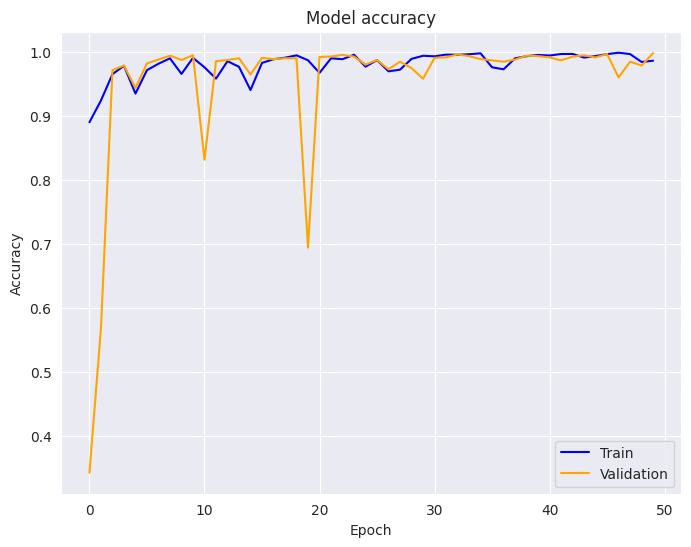

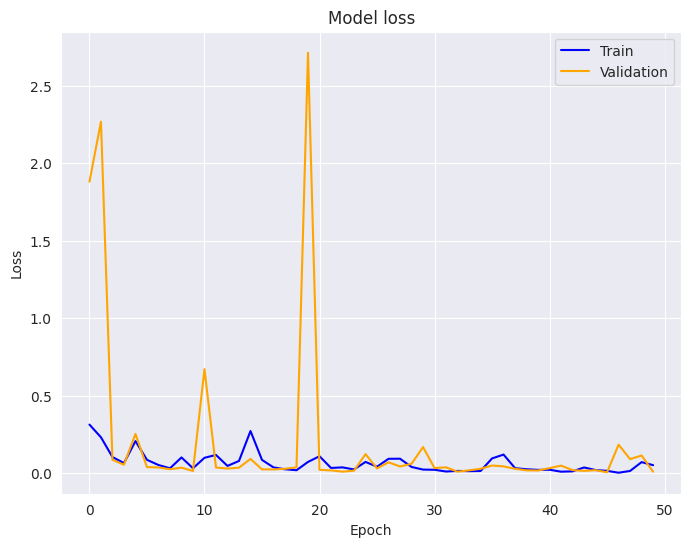

In [29]:
import matplotlib.pyplot as plt

# Define the function to plot accuracy and loss separately
def plot_model_performance(history, epochs):
    # Extract training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Define the range of epochs
    epochs_range = range(epochs)

    # Plot training & validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Train', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation', color='orange')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)  # Add grid
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Train', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation', color='orange')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)  # Add grid
    plt.show()

# Call the function to display performance
plot_model_performance(EfficientNetB3_history, epochs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step


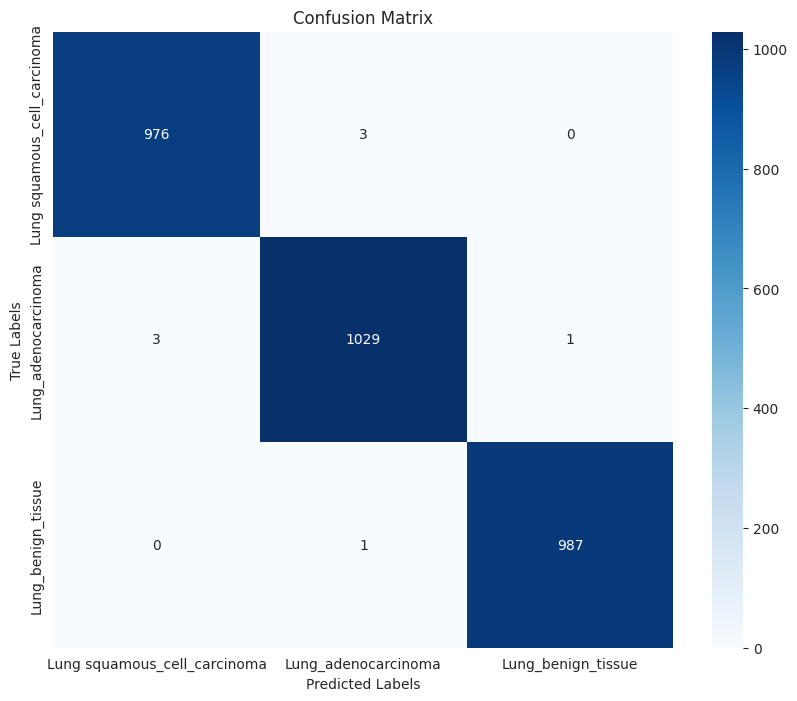

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def get_pred(model, data_generator):
    """
    Get predictions from the model on the given data generator.
    """
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
    return y_pred_classes


def plot_confusion_matrix(data_generator, y_pred_classes):
    """
    Plot confusion matrix for the given predictions and data generator.
    """
    y_true = data_generator.classes  # True labels
    class_names = list(data_generator.class_indices.keys())  # Class names
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
# Get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# Plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [14]:
test_gen.reset()
predictions = EfficientNetB3_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step
                              precision    recall  f1-score   support

Lung squamous_cell_carcinoma       1.00      1.00      1.00       979
         Lung_adenocarcinoma       1.00      1.00      1.00      1033
          Lung_benign_tissue       1.00      1.00      1.00       988

                    accuracy                           1.00      3000
                   macro avg       1.00      1.00      1.00      3000
                weighted avg       1.00      1.00      1.00      3000



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


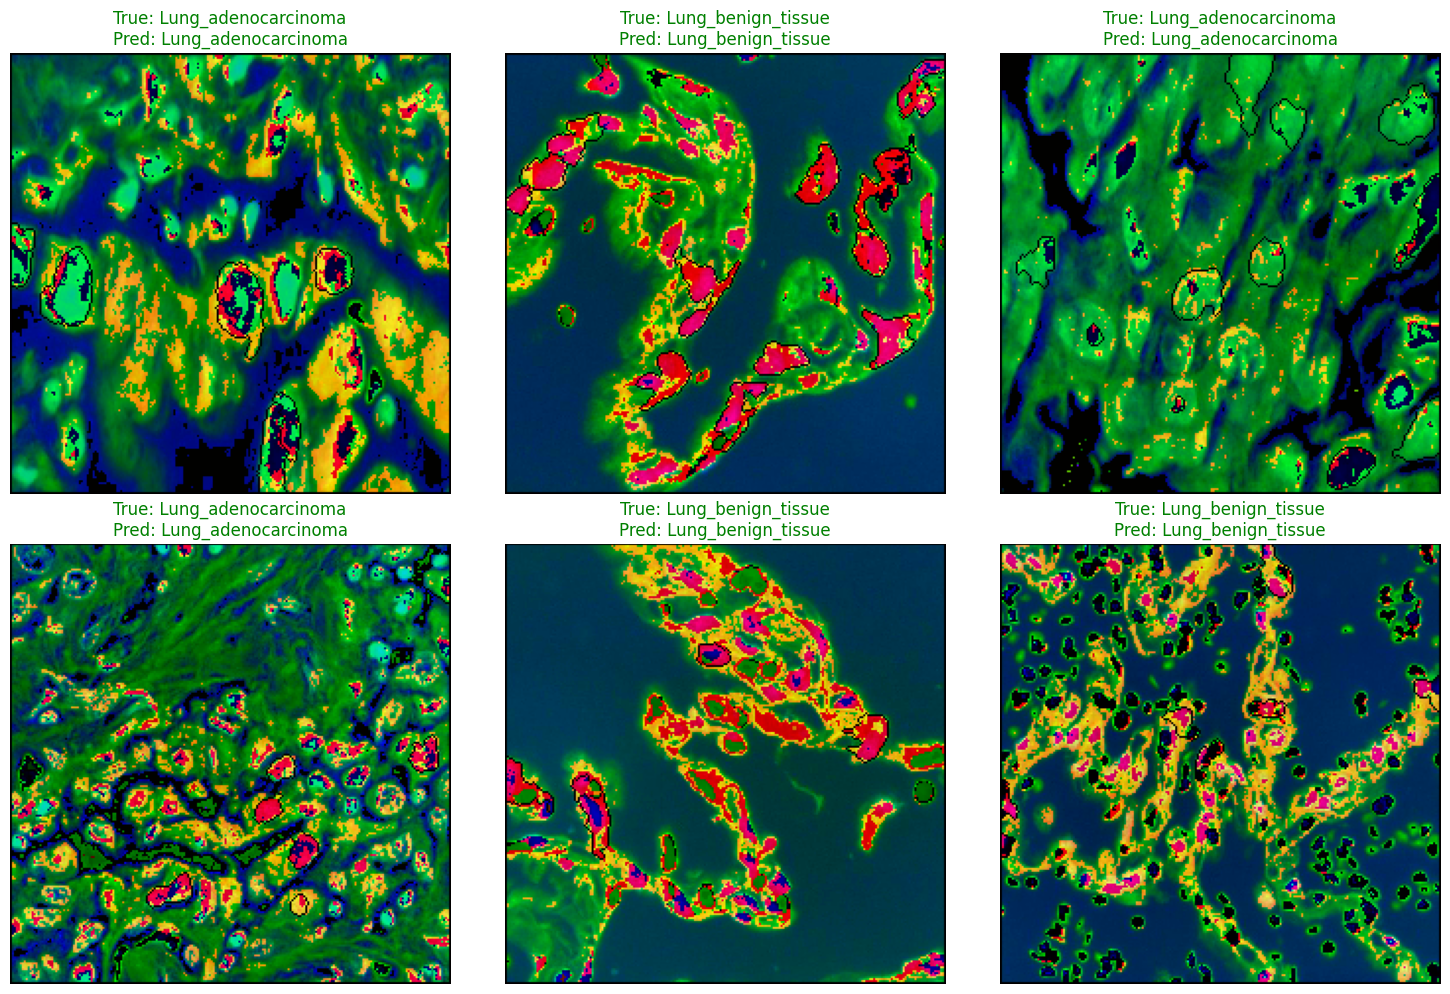

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Select 6 random images from the test set
num_samples = 6
images, true_labels = next(test_gen)  # Get a batch of images

# Get predictions from the model
preds = EfficientNetB3_model.predict(images[:num_samples])  # Use EfficientNetB3_model
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(true_labels[:num_samples], axis=1)

# Class names
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Display the images with their true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    true_class = classes[y_true[i]]
    pred_class = classes[y_pred[i]]
    plt.title(f"True: {true_class}\nPred: {pred_class}", color='green' if true_class == pred_class else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

